# CSAPR example PyDDA single doppler

In [31]:
import pydda
import pyart
%pylab inline
import cartopy.crs as ccrs
from distributed import LocalCluster, Client

Populating the interactive namespace from numpy and matplotlib


In [2]:
xsapr = pyart.io.read('110635.mdv')
xsapr.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float64 and shape: (6120,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float32 and shape: (6120, 983)>
		units: dBZ
		standard_name: equivalent_reflectivity_factor
		long_name: Reflectivity
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	velocity:
		data: <ndarray of type: float32 and shape: (6120, 983)>
		units: meters_p

In [40]:
display = pyart.graph.RadarDisplay(xsapr)

In [4]:
gatefilter = pyart.filters.GateFilter(xsapr)
vel_texture = pyart.retrieve.calculate_velocity_texture(xsapr)
xsapr.add_field('velocity_texture', vel_texture, replace_existing=True)
#gatefilter.exclude_below('normalized_coherent_power',0.5)
gatefilter.exclude_above('velocity_texture', 4)

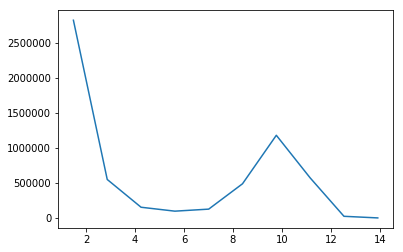

In [35]:
bins, hist = np.histogram(vel_texture["data"])
plt.plot(hist[1:], bins)

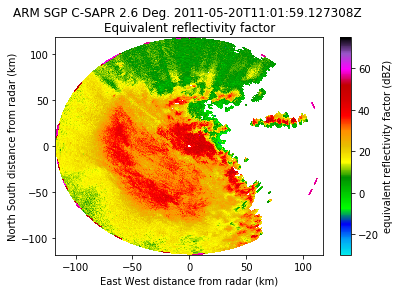

In [40]:
display.plot_ppi('reflectivity', gatefilter=gatefilter, sweep=3)

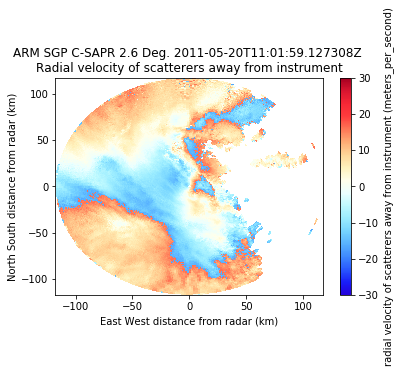

In [41]:
display.plot_ppi('velocity', gatefilter=gatefilter, sweep=3)

In [41]:
dealiased_vel = pyart.correct.dealias_region_based?

In [ ]:
dealiased_vel = pyart.correct.dealias_region_based

In [42]:
dealiased_vel = pyart.correct.dealias_region_based(xsapr, gatefilter=gatefilter)
xsapr.add_field('corrected_velocity', dealiased_vel, replace_existing=True)

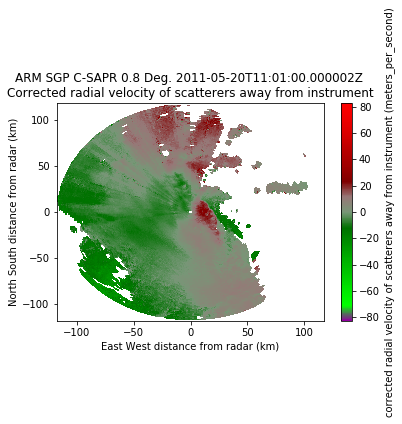

In [43]:
n_sweeps = xsapr.nsweeps
display.plot_ppi('corrected_velocity', sweep=0, cmap='pyart_NWSVel')

In [57]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000), bsp=1.0, 
               min_radius=750, h_factor=1.0, nb=1.0,
               fields=['DT', 'VT'], origin=None, gatefilter=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        weighting_function='Cressman',
        gridding_algo='map_gates_to_grid',
        h_factor=h_factor,
        min_radius=min_radius,
        bsp=bsp,
        nb=nb,
        gatefilter=gatefilter)
    print(time.time() - bt, 'seconds to grid radar')
    return grid

In [108]:
xsapr.fields['reflectivity']["data"] = np.ma.masked_where(gatefilter.gate_excluded, xsapr.fields['reflectivity']["data"])
the_grid = grid_radar(xsapr, grid_shape=(81, 401, 401), xlim=(-100000, 100000), ylim=(-100000, 100000),
                      zlim=(0, 20000.), min_radius=250, h_factor=0.5, fields=['reflectivity', 'corrected_velocity'],
                      gatefilter=gatefilter)

12.225692510604858 seconds to grid radar


In [109]:
display = pyart.graph.GridMapDisplay(the_grid)

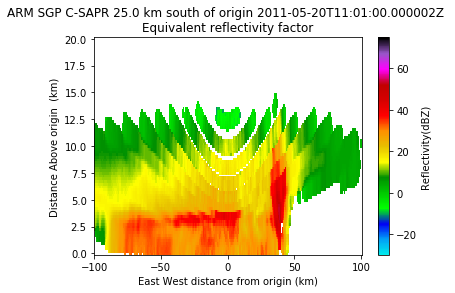

In [110]:
display.plot_latitudinal_level("reflectivity", 150)

In [111]:
pyart.io.write_grid('CSAPR.nc', the_grid)

In [113]:
the_grid = pydda.constraints.make_constraint_from_era_interim(the_grid)

Download ERA Interim data...
2019-03-18 09:57:15 ECMWF API python library 1.5.0
2019-03-18 09:57:15 ECMWF API at https://api.ecmwf.int/v1
2019-03-18 09:57:16 Welcome Robert Jackson
2019-03-18 09:57:17 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web-API+Troubleshooting or contact servicedesk@ecmwf.int
2019-03-18 09:57:17 In case of delays, please check  service activity page https://apps.ecmwf.int/webapi-activity/
2019-03-18 09:57:17 Request submitted
2019-03-18 09:57:17 Request id: 5c8fb1cdcad5191f488a66e7
2019-03-18 09:57:17 Request is submitted
2019-03-18 09:57:19 Request is queued
2019-03-18 09:57:59 Request is active
Calling 'nice mars /tmp/af/05/tmp-_marsf0onxw.req'
mars - WARN -
mars - WARN - From 29 January 2019 10AM (UTC) MARS uses the interpolation
mars - WARN - provided by the MIR library. For more details, see
mars - WARN - https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR
mars - WARN -
PPDIR is /var/tmp/ppdir/x86_64
mars

In [116]:
pyart.io.write_grid('CSAPR_with_era_interim.nc', the_grid)

In [5]:
the_grid = pyart.io.read_grid('CSAPR_with_era_interim.nc')

/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/site-packages/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/site-packages/pyart/io/cfradial.py:376: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


In [49]:
client

Client Scheduler: tcp://127.0.0.1:38879 Dashboard: http://127.0.0.1:46026/status,Cluster Workers: 2 Cores: 8 Memory: 67.48 GB


In [48]:
cluster = LocalCluster(n_workers=2)
client = Client(cluster)

In [50]:
u_init = the_grid.fields["U_erainterim"]["data"]
v_init = the_grid.fields["V_erainterim"]["data"]
w_init = the_grid.fields["W_erainterim"]["data"]

winds = pydda.retrieval.get_dd_wind_field([the_grid], u_init, v_init, w_init, 
                                          Cmod=1e-5, Co=10.0, model_fields=["erainterim"],
                                          )

/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/site-packages/pydda-0.3.1-py3.6.egg/pydda/retrieval/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2)/(2 * Re * slantr))


Starting solver 
rmsVR = 275.0867922721716
Total points:6611961.0


distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 1.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 1.28s.  This is often caused by long-running GIL-holding functions or moving large chu

distributed.core - WARNING - Event loop was unresponsive in Nanny for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 4.18s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - WARNING - Event loop was unresponsive in Nanny for 7.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 7.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Scheduler for 8.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 8.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - WARNING - Event loop was unresponsive in Nanny for 8.60s.  This is often caused by long-running GIL-holding functions or moving large chu

KeyboardInterrupt: 

/home/rjackson/anaconda3/envs/pyart-2018/lib/python3.6/site-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


(-50, 50)

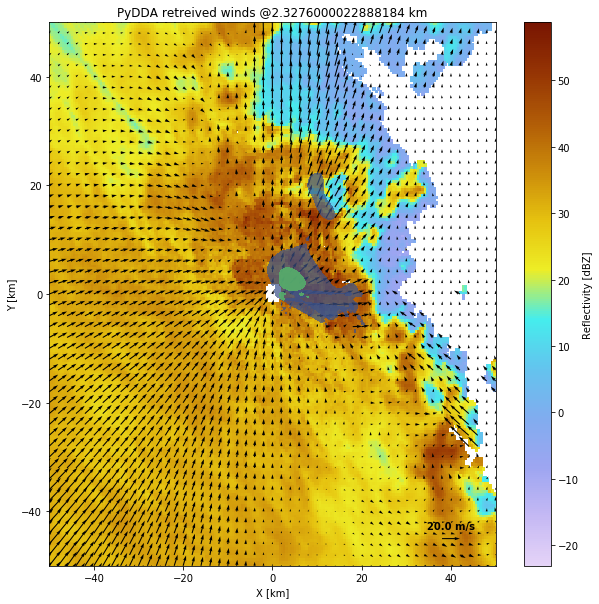

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax = pydda.vis.plot_horiz_xsection_quiver(winds, ax=ax, level=8, background_field='reflectivity',
                                          quiverkey_len=20.0, quiver_spacing_x_km=2.0,
                                          quiver_spacing_y_km=2.0, w_vel_contours=[1, 3, 5])
plt.xlim([-50, 50])
plt.ylim([-50, 50])

In [23]:
pydda.vis.plot_horiz_xsection_quiver?

In [47]:
del client, cluster